# Toy Experiment: Encrypted Inference with TFHE (Concrete-ML)

This notebook presents a first experiment with **Fully Homomorphic Encryption (FHE)** using the `concrete-ml` library.  
We use the **Digits dataset** (8×8 grayscale images of handwritten digits) as a *toy dataset* to validate the workflow before moving to larger datasets such as MNIST or CIFAR.

The notebook follows a simple pipeline:

1. **Data preparation**  
   - Load the Digits dataset  
   - Normalize the pixel values and split into training and test sets  
   - Visualize some samples and the class distribution  

2. **Training in clear**  
   - Train a quantized neural network (Multi-Layer Perceptron with 2 hidden layers, 5-bit weights and activations)  
   - Evaluate accuracy on the test set  
   - Inspect the confusion matrix and some example predictions  

3. **Compilation to FHE**  
   - Compile the trained model into an FHE-compatible circuit  
   - Run predictions in two modes:  
     - **simulate**: runs the encrypted circuit on plaintext (fast, for debugging)  
     - **execute**: performs real encrypted inference (slow, but privacy-preserving)  

4. **Evaluation**  
   - Compare accuracy in clear, simulate, and execute modes  
   - Measure inference time and memory usage  
   - Analyze prediction differences between clear, simulate, and execute  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from concrete.ml.sklearn import NeuralNetClassifier
import torch, random, time, psutil, os, tracemalloc

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# If you ever run on GPU and want determinism:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset preparation

In this section, we load the **Digits dataset** from scikit-learn.  
This dataset contains 8×8 grayscale images of handwritten digits (0–9), with each image represented by 64 features (pixel intensities).  
It is a convenient *toy dataset* to validate our workflow before moving to larger datasets such as MNIST.

We start by:
- Loading the dataset and displaying its basic characteristics (number of samples, features, and classes).  
- Visualizing a few sample digit images to get an intuition of the data.  
- Plotting the distribution of classes to ensure the dataset is balanced.  
- Normalizing the pixel values to the range [0, 1] for stable training.  
- Splitting the dataset into **training (80%)** and **test (20%)** sets.  

This preprocessing step ensures the data is ready for training the neural network under both cleartext and encrypted settings.

Number of samples:  1797
Number of features per sample:  64
Number of classes:  10
Classes: [0 1 2 3 4 5 6 7 8 9]


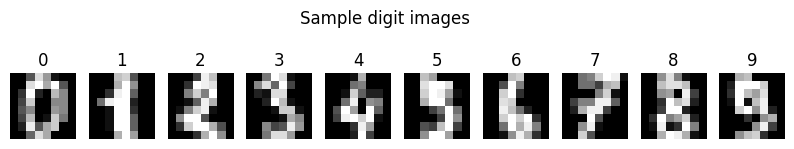

Class distribution:
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64


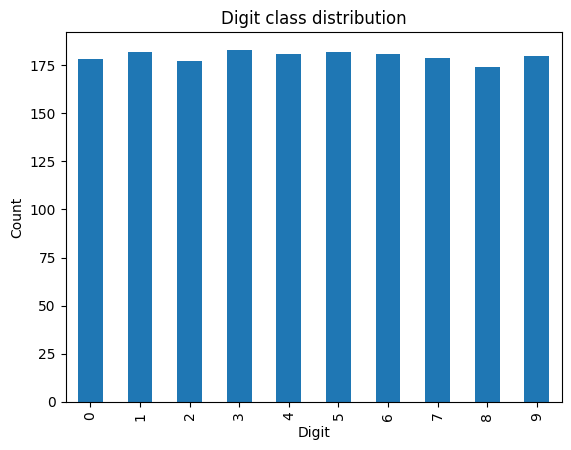

Dataset ready for training
X_train shape: (1437, 64)
X_test shape: (360, 64)
y_train shape: (1437,)
y_test shape: (360,)


In [2]:
digits = load_digits()
X, y = digits.data, digits.target

print("Number of samples: ",X.shape[0])
print("Number of features per sample: ",X.shape[1])
print("Number of classes: ", len(np.unique(y)))
print("Classes:", np.unique(y))


plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(str(y[i]))
    plt.axis('off')
plt.suptitle("Sample digit images")
plt.show()


value_counts = pd.Series(y).value_counts().sort_index()
print("Class distribution:")
print(value_counts)

value_counts.plot(kind='bar', title="Digit class distribution", xlabel="Digit", ylabel="Count")
plt.show()

# Normalizing the features to [0, 1]
X /= 16.0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirming shapes
print("Dataset ready for training")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

## Model definition and training in clear

We now define a **quantized neural network** using the `NeuralNetClassifier` provided by Concrete-ML.  
The architecture is a Multi-Layer Perceptron (MLP) with:
- **2 hidden layers**,  
- **5-bit quantization** for both weights and activations,  
- **32-bit accumulators**,  
- mini-batch training with size 32.  

This model is first trained on the **training set in cleartext** to serve as a baseline.  
We then evaluate its performance on the **test set**, computing the accuracy and analyzing how well the model recognizes digits before moving to encrypted inference.

In [3]:
# Model def

model = NeuralNetClassifier(
    module__n_layers=2,
    module__n_w_bits=5,
    module__n_a_bits=5,
    module__n_accum_bits=32,
    batch_size=32,
    verbose=1
)
# Training
print("Training the model on clear data")
model.fit(X_train, y_train)

# Evaluating accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on clear test set:", acc * 100, "%")

Training the model on clear data
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9070       0.8993        0.3254  0.4970
      2        0.2185       0.9410        0.1922  0.4902
      3        0.1409       0.9583        0.1491  0.4953
      4        0.1043       0.9722        0.1155  0.4977
      5        0.0812       0.9549        0.1100  0.4895
      6        0.0584       0.9201        0.1935  0.4682
      7        0.0469       0.9514        0.1362  0.4612
      8        0.0493       0.9306        0.1975  0.4607
      9        0.0335       0.9618        0.1554  0.4320
     10        0.0268       0.9479        0.1299  0.4336
Accuracy on clear test set: 97.22222222222221 %


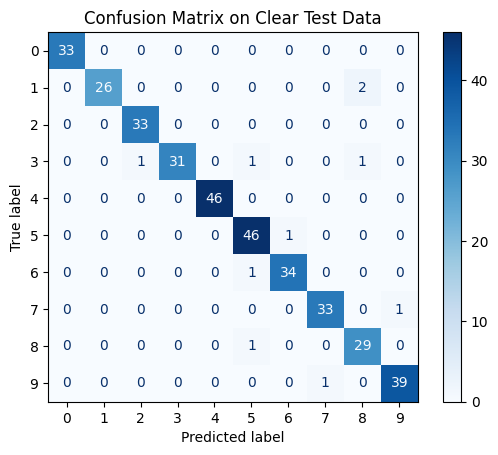

In [4]:
# Insight into which digits are most often confused:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Clear Test Data")
plt.show()

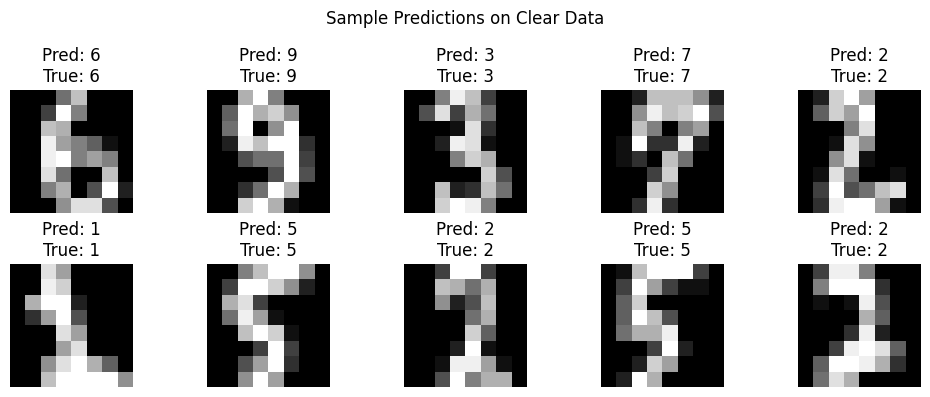

In [5]:
# Correct and incorrect predictions
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(8, 8), cmap='gray')
    plt.title("Pred: " + str(y_pred[i]) + "\nTrue: " + str(y_test[i]))
    plt.axis('off')
plt.suptitle("Sample Predictions on Clear Data")
plt.tight_layout()
plt.show()

In [6]:
# Missclassifed samples:
misclassified = np.where(y_pred != y_test)[0]
print("Number of misclassified samples:", len(misclassified))
if len(misclassified) > 0:
    for i in misclassified[:5]:
        print("Index " + str(i) + ": Predicted " + str(y_pred[i]) + ", True " + str(y_test[i]))

Number of misclassified samples: 10
Index 133: Predicted 9, True 7
Index 149: Predicted 5, True 3
Index 156: Predicted 2, True 3
Index 159: Predicted 7, True 9
Index 166: Predicted 8, True 3


## Compilation to FHE and encrypted inference

Once the model has been trained and validated in clear, we compile it into a circuit compatible with FHE using Concrete-ML.  
This step translates the neural network into a form that can be evaluated directly on encrypted data.

We then evaluate the model in two modes:

1. **Simulation (`fhe="simulate"`)**  
   - Runs the encrypted circuit on plaintext data.  
   - Useful for checking correctness and debugging.  
   - Provides the same accuracy as real FHE but with much lower runtime and memory usage.  

2. **Execution (`fhe="execute"`)**  
   - Performs real homomorphic inference on encrypted data.  
   - This is the *true* privacy-preserving mode, but it is significantly slower and more memory-intensive.  

During these runs, we measure:  
- **Accuracy** on the test set to compare with the clear baseline.  
- **Inference time** (total and per sample) to quantify computational cost.  
- **Memory usage**, including Python allocator peak and OS-level resident set size (RSS).  
- **Prediction agreement** between clear, simulate, and execute modes to verify that encrypted inference produces identical results to the clear model.


In [7]:
# Compiling
print("Compiling model to FHE:")
t0_compile = time.time()
model.compile(X_train)
t1_compile = time.time()
compile_time = t1_compile - t0_compile
print("Compile time (s):", round(compile_time, 2))

# Simulation run
print("\nRunning FHE SIMULATION on full test set ({} samples)".format(len(X_test)))
t0_sim = time.time()
y_pred_sim = model.predict(X_test, fhe="simulate")
t1_sim = time.time()
sim_time = t1_sim - t0_sim
sim_acc = accuracy_score(y_test, y_pred_sim)
print("Accuracy (simulate):", sim_acc * 100.0, "%")
print("Total time (simulate):", sim_time, "s")
print("Avg. time/sample (simulate):", sim_time / len(X_test), "s")



# Real FHE execution
print("\nRunning REAL FHE EXECUTION on full test set ({} samples)".format(len(X_test)))

# Peak memory via tracemalloc
tracemalloc.start()
proc = psutil.Process(os.getpid())
rss_before = proc.memory_info().rss

t0_exec = time.time()
y_pred_fhe = model.predict(X_test, fhe="execute")   # real FHE
t1_exec = time.time()

current_bytes, peak_bytes = tracemalloc.get_traced_memory()
tracemalloc.stop()
rss_after = proc.memory_info().rss

exec_time = t1_exec - t0_exec
exec_acc = accuracy_score(y_test, y_pred_fhe)
print("Accuracy (execute):", exec_acc * 100.0, "%")
print("Total time (execute):", exec_time, "s")
print("Avg. time/sample (execute):", exec_time / len(X_test), "s")


# Memory notes:
# peak_bytes is Python allocator peak (underestimates native/C++ buffers)
# - rss_* are OS-level resident memory snapshots (not true peak)
print("Python-level peak (tracemalloc):", peak_bytes / 1e6, "MB")
print("RSS before:", rss_before / 1e6, "MB | RSS after:", rss_after / 1e6, "MB")


# Agreement analysis
diff_sim_clear = int(np.sum(y_pred_sim != y_pred))
diff_exec_clear = int(np.sum(y_pred_fhe != y_pred))
diff_exec_sim   = int(np.sum(y_pred_fhe != y_pred_sim))

print("\nPrediction differences:")
print("simulate vs clear:", diff_sim_clear)
print("execute  vs clear:", diff_exec_clear)
print("execute  vs simulate:", diff_exec_sim)

# metrics
METRICS = {
    "compile_time": compile_time,
    "clear_acc": float(accuracy_score(y_test, y_pred)),
    "sim_acc": float(sim_acc),
    "exec_acc": float(exec_acc),
    "sim_time": float(sim_time),
    "exec_time": float(exec_time),
    "sim_time_per_sample": float(sim_time / len(X_test)),
    "exec_time_per_sample": float(exec_time / len(X_test)),
    "py_peak_mb": float(peak_bytes / 1e6),
    "rss_before_mb": float(rss_before / 1e6),
    "rss_after_mb": float(rss_after / 1e6),
    "diff_sim_clear": diff_sim_clear,
    "diff_exec_clear": diff_exec_clear,
    "diff_exec_sim": diff_exec_sim,
    "n_test": int(len(X_test)),
}

Compiling model to FHE:
Compile time (s): 1.97

Running FHE SIMULATION on full test set (360 samples)
Accuracy (simulate): 97.22222222222221 %
Total time (simulate): 26.834519624710083 s
Avg. time/sample (simulate): 0.07454033229086134 s

Running REAL FHE EXECUTION on full test set (360 samples)
Accuracy (execute): 97.22222222222221 %
Total time (execute): 1639.4104526042938 s
Avg. time/sample (execute): 4.5539179239008165 s
Python-level peak (tracemalloc): 0.607795 MB
RSS before: 937.5744 MB | RSS after: 2595.9424 MB

Prediction differences:
simulate vs clear: 0
execute  vs clear: 0
execute  vs simulate: 0


## Results and analysis

The results show that **encrypted inference with FHE** achieves the same accuracy as clear inference:

- Accuracy remains stable across all modes (approximately 97.2%), with no prediction differences between *clear*, *simulate*, and *execute*.  
- This demonstrates that compiling the neural network to FHE preserves correctness.

However, there is a **significant performance gap** between simulation and real FHE execution:

- **Simulation** completed in approximately 27 seconds (~0.07 s/sample), which is relatively fast and useful for debugging.  
- **Execution** on real encrypted data required  approximately 1640 seconds (~4.55 s/sample), which is several orders of magnitude slower.  
- **Memory usage** also increased, with the resident set size (RSS) growing from around 938 MB to around 2.6 GB during execution.

These results illustrate a fundamental trade-off of homomorphic encryption:
- **Strong privacy guarantees** (data remains encrypted throughout computation).  
- **High computational overhead** in terms of runtime and memory.  

This toy example validates the feasibility of FHE-based inference while highlighting the efficiency challenges that remain before scaling to larger models and datasets.


In [10]:
print("Summary: Toy Digits Neural Network under FHE")
print("Model: MLP with 2 hidden layers, 5-bit weights/activations, 32-bit accumulators")
print("Train/Test:", len(X_train), "/", len(X_test), "samples")

print("\nAccuracy:")
print(" - Clear (quantized):", METRICS["clear_acc"] * 100.0, "%")
print(" - Simulate (FHE circuit, plaintext):", METRICS["sim_acc"] * 100.0, "%")
print(" - Execute (REAL FHE):", METRICS["exec_acc"] * 100.0, "%")

print("\nTiming:")
print(" - Compile time:", METRICS["compile_time"], "s")
print(" - Simulate total:", METRICS["sim_time"], "s  | per sample:", METRICS["sim_time_per_sample"], "s")
print(" - Execute  total:", METRICS["exec_time"], "s  | per sample:", METRICS["exec_time_per_sample"], "s")

print("\nMemory:")
print(" - Python allocator peak (tracemalloc):", METRICS["py_peak_mb"], "MB")
print(" - RSS before / after execute:", METRICS["rss_before_mb"], "/", METRICS["rss_after_mb"], "MB")

print("\nPrediction agreement (counts over", METRICS["n_test"], "test samples):")
print(" - simulate vs clear:   ", METRICS["diff_sim_clear"])
print(" - execute  vs clear:   ", METRICS["diff_exec_clear"])
print(" - execute  vs simulate:", METRICS["diff_exec_sim"])

Summary: Toy Digits Neural Network under FHE
Model: MLP with 2 hidden layers, 5-bit weights/activations, 32-bit accumulators
Train/Test: 1437 / 360 samples

Accuracy:
 - Clear (quantized): 97.22222222222221 %
 - Simulate (FHE circuit, plaintext): 97.22222222222221 %
 - Execute (REAL FHE): 97.22222222222221 %

Timing:
 - Compile time: 1.9689881801605225 s
 - Simulate total: 26.834519624710083 s  | per sample: 0.07454033229086134 s
 - Execute  total: 1639.4104526042938 s  | per sample: 4.5539179239008165 s

Memory:
 - Python allocator peak (tracemalloc): 0.607795 MB
 - RSS before / after execute: 937.5744 / 2595.9424 MB

Prediction agreement (counts over 360 test samples):
 - simulate vs clear:    0
 - execute  vs clear:    0
 - execute  vs simulate: 0
